<a href="https://colab.research.google.com/github/RostislavKorst/Generative-Models-2025/blob/main/Assignment%202/2_gan_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2025, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset.

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

In [3]:
# import ssl 
# ssl._create_default_https_context = ssl._create_stdlib_context

### Define parameters & data loading

In [2]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 51.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.64MB/s]


Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

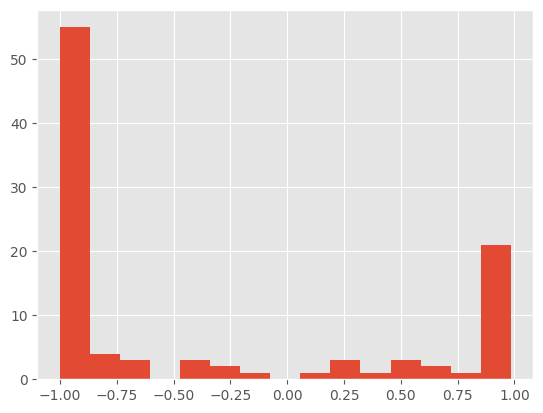

In [5]:
# гистограмма показывает значение яркости пикселей на картинке из датасета
# Видно, что в основном преобладают черные и белые пиксели, мало промежуточных цветов -- изображение четкое
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [3]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

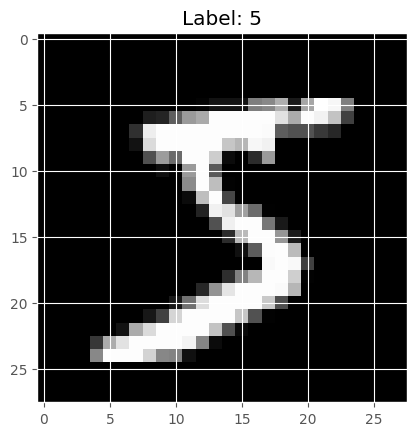

In [4]:
# show image sample with matplotlib
img, label = mnist_dataset[0]
img_denorm = denorm(img)
plt.imshow(img_denorm.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [5]:
# define the dataloader
data_loader = torch.utils.data.DataLoader(
    dataset=mnist_dataset,
    batch_size=batch_size,
    shuffle=True
)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.linear1 = nn.Linear(latent_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear3 = nn.Linear(hidden_size, image_size)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.linear1 = nn.Linear(image_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is 1
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        x = F.leaky_relu(self.linear1(x), 0.2)
        x = F.leaky_relu(self.linear2(x), 0.2)
        x = torch.sigmoid(self.linear3(x))
        return x

### Create the Generator and Discriminator

In [7]:
# create new Generator model
# G = Generator...
G = Generator(latent_size, image_size, hidden_size)

# create new Discriminator model
# D = Discriminator...
D = Discriminator(image_size, hidden_size)

In [8]:
# show the output of model
y = G(torch.randn(2, latent_size))
y.shape

torch.Size([2, 784])

In [9]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR)
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR)

Discriminator Training

In [10]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images):

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)


    outputs = D_model(images)
    # Loss for real images
    d_loss_real = criterion(outputs, real_labels)

    # Предсказания вероятностей (логиты) для изображений из датасета (1 -- изображение является изображением из датасета)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    #! Генератор создает фейковые изображения из шума (прогоняет их через полносвязную есть, модифицируя веса тензора)
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    # Предсказания вероятностей (логиты) для сгенерированных изображений (0 -- изображение является сгенерированным)
    fake_score = outputs

    # Высчитываются 2 ошибки: на сколько хорошо дескриминатор распознает истинные изображения и сгенерированные
    
    d_loss_fake = criterion(outputs, fake_labels)

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()

    '''
    В идеале в конце дескриминатор не должен корректно уметь предсказывать ихображения. 
    real_score и fake_score должны быть близки к значению 0.5.
    '''
    return d_loss, real_score, fake_score

Generator Training

In [11]:
def train_generator(G_model, D_model):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    #! Генератор создает фейковые изображения из шума (прогоняет их через полносвязную есть, модифицируя веса тензора)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    # Высчитывается ошибка, на сколько реальные метки совпадают с теми, которые предсказал дескриминатор по сгенерированному изображению
    g_loss = criterion(D_model(fake_images), labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [12]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    # формируем начальную заготовку для генератора, которая представляет собой гаусовский шум
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    '''
    Обратим внимание, что на одной картинке будет несколько изображений,
    потому что мы работаем с батчами данных.
    '''
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [18]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)

        # Train the generator
        g_loss, fake_images = train_generator(G, D)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.0990, g_loss: 4.9022, D(x): 0.96, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.1069, g_loss: 3.1893, D(x): 0.95, D(G(z)): 0.05
Epoch [0/300], Step [600/600], d_loss: 0.8068, g_loss: 3.6260, D(x): 0.84, D(G(z)): 0.29
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1525, g_loss: 3.4436, D(x): 0.94, D(G(z)): 0.07
Epoch [1/300], Step [400/600], d_loss: 0.3805, g_loss: 4.0080, D(x): 0.86, D(G(z)): 0.11
Epoch [1/300], Step [600/600], d_loss: 0.2161, g_loss: 3.2909, D(x): 0.96, D(G(z)): 0.15
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 1.9208, g_loss: 2.6268, D(x): 0.59, D(G(z)): 0.42
Epoch [2/300], Step [400/600], d_loss: 0.6861, g_loss: 2.4511, D(x): 0.78, D(G(z)): 0.17
Epoch [2/300], Step [600/600], d_loss: 1.0104, g_loss: 3.2145, D(x): 0.69, D(G(z)): 0.21
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3707, g_loss: 2.6289, D(x): 0.89, D(G(z)): 0.16
Epoch [3/300], Step [400/6

In [20]:
# show output after epochs training
img = Image.open(os.path.join(sample_dir, "fake_images-0225.png"))
img.show() 

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpl6r6zw67.PNG'


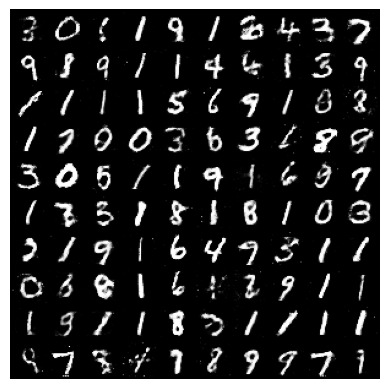

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(os.path.join(sample_dir, "fake_images-0225.png"))
plt.imshow(img)
plt.axis('off')
plt.show()

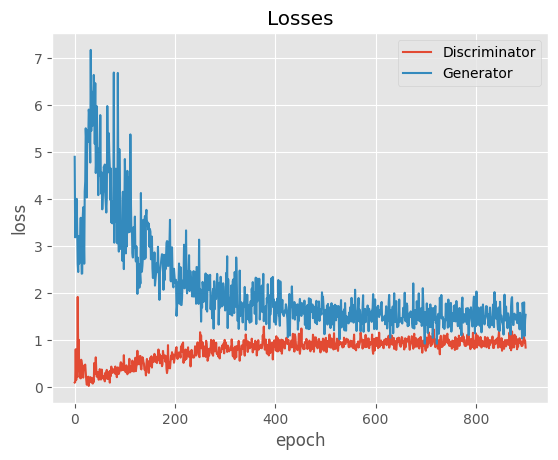

In [23]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

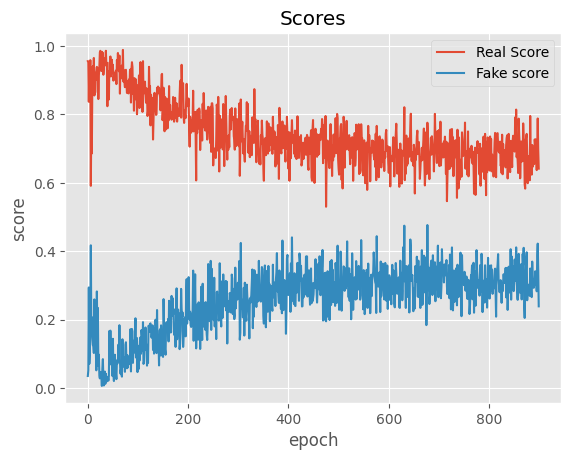

In [24]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [3]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

100%|██████████| 170M/170M [00:03<00:00, 54.0MB/s] 


Label:  6


(array([ 1.,  0.,  0.,  2.,  0.,  2.,  1.,  2.,  3.,  5., 14., 20., 16.,
        19., 15.]),
 array([-0.47450978, -0.43790847, -0.40130717, -0.36470586, -0.32810453,
        -0.29150322, -0.25490192, -0.21830061, -0.18169931, -0.145098  ,
        -0.10849669, -0.07189538, -0.03529407,  0.00130724,  0.03790855,
         0.07450986]),
 <BarContainer object of 15 artists>)

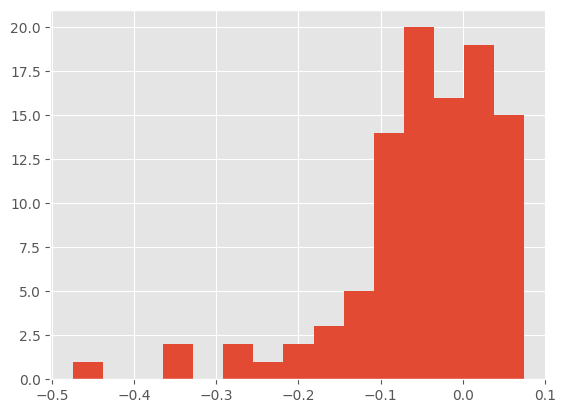

In [6]:
# Заметим, что здесь в рассматриваемой части изображения присутствуют моды в интенсивности пикселей
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[0, 5:15, 5:15].flatten(), bins=15)

(array([ 1.,  0.,  1.,  1.,  0.,  3.,  1.,  3.,  6.,  8., 23., 17., 19.,
        14.,  3.]),
 array([-0.69411767, -0.66588235, -0.63764709, -0.60941178, -0.58117646,
        -0.5529412 , -0.52470589, -0.4964706 , -0.46823528, -0.44      ,
        -0.41176471, -0.38352939, -0.35529411, -0.32705882, -0.29882351,
        -0.27058822]),
 <BarContainer object of 15 artists>)

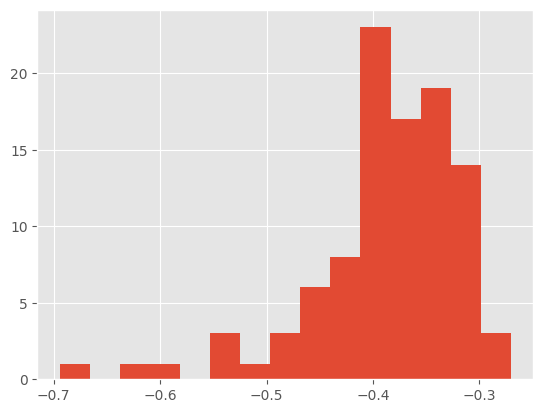

In [7]:
plt.hist(img[1, 5:15, 5:15].flatten(), bins=15)

(array([ 1.,  0.,  1.,  2.,  0.,  3.,  2.,  6., 14., 26., 14., 17.,  6.,
         3.,  5.]),
 array([-0.87450981, -0.85620916, -0.83790851, -0.81960785, -0.8013072 ,
        -0.78300655, -0.7647059 , -0.74640524, -0.72810459, -0.70980394,
        -0.69150329, -0.67320263, -0.65490198, -0.63660133, -0.61830068,
        -0.60000002]),
 <BarContainer object of 15 artists>)

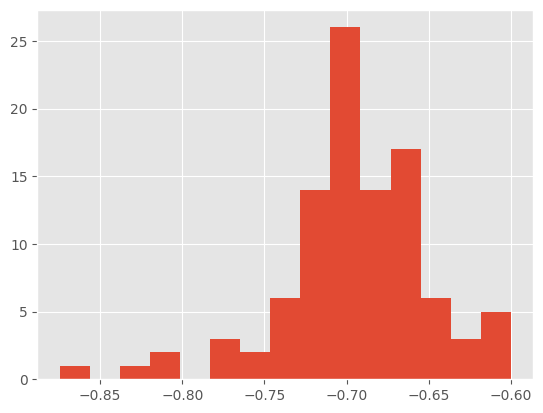

In [8]:
plt.hist(img[2, 5:15, 5:15].flatten(), bins=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


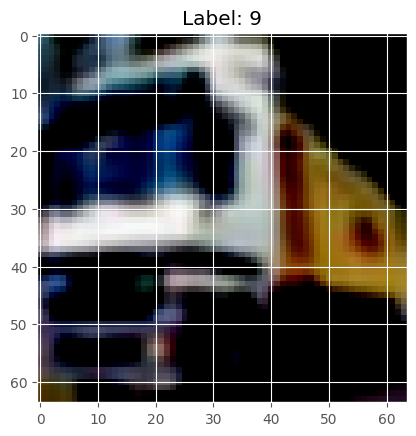

In [9]:
# show  image sample with matplotlib
img, label = cifar_dataset[1]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.show()

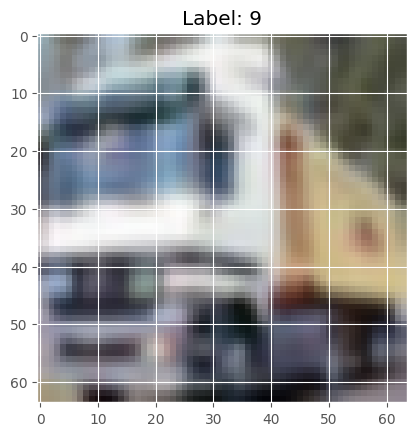

In [15]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    out = (img + 1) / 2
    return out.clamp(0, 1)

# show  image sample with matplotlib
img, label = cifar_dataset[1]
img_denorm = denorm(img)
plt.imshow(img_denorm.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.show()

In [13]:
def collate_fn(batch):
    """
    Collate function для применения денормализации к батчу данных
    """
    # Разделяем изображения и метки
    images, labels = zip(*batch)
    
    # Применяем денормализацию к каждому изображению в батче
    denormalized_images = [denorm(img) for img in images]
    
    # Собираем тензоры обратно
    images_tensor = torch.stack(denormalized_images)
    labels_tensor = torch.tensor(labels)
    
    return images_tensor, labels_tensor

In [4]:
# create the dataloader
cifar_loader = torch.utils.data.DataLoader(
    dataset=cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.workers,
    # collate_fn=collate_fn
)

### DCGAN implementation

In [5]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        ##
        self.main = nn.Sequential(
            # Input: nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State: ngf x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: nc x 64 x 64
        )

    def forward(self, x):
        ##
        return self.main(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()
        ##
        self.main = nn.Sequential(
            # Input: nc x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )

    def forward(self, x):
        ##
        return self.main(x).view(-1, 1)

In [6]:
# Инициализация весов (важно для DCGAN)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# create new Generator model
# DCG = DCGenerator...
DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf)

# create new Discriminator model
# DCD = DCDiscriminator...
DCD = DCDiscriminator(CFG.nc, CFG.ndf)

In [8]:
# Применяем инициализацию весов
DCG.apply(weights_init)
DCD.apply(weights_init)

DCDiscriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [9]:
# show the output of model
y = DCG(torch.randn(2, CFG.nz, 1, 1))
y.shape

torch.Size([2, 3, 64, 64])

In [10]:
# define the criterion is nn.BCELoss()
criterion_dc = nn.BCELoss()
## Define the optimizer for generator and discrimator
dc_d_optimizer = torch.optim.Adam(DCD.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
dc_g_optimizer = torch.optim.Adam(DCG.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

# lr schedulers can negative effect on GAN training

In [ ]:
# feel free to reuse your training functions

In [19]:
# def reset_grad_dc():
#     dc_d_optimizer.zero_grad()
#     dc_g_optimizer.zero_grad()

In [11]:
def train_discriminator_dc(D_model, G_model, images, batch_size):
    dc_d_optimizer.zero_grad()
    
    real_labels = torch.ones(batch_size, 1).to(CFG.device)
    fake_labels = torch.zeros(batch_size, 1).to(CFG.device)
    
    # Real images
    outputs = D_model(images)
    d_loss_real = criterion_dc(outputs, real_labels)
    real_score = outputs
    
    # Fake images
    z = torch.randn(batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = G_model(z)
    outputs = D_model(fake_images.detach())
    d_loss_fake = criterion_dc(outputs, fake_labels)
    fake_score = outputs
    
    # Total loss
    d_loss = d_loss_real + d_loss_fake
    
    # reset_grad_dc()
    d_loss.backward()
    
    dc_d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [12]:
def train_generator_dc(G_model, D_model, batch_size):
    dc_g_optimizer.zero_grad()
    
    z = torch.randn(batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(CFG.device)
    
    g_loss = criterion_dc(D_model(fake_images), labels)
    
    # reset_grad_dc()
    g_loss.backward()
    
    dc_g_optimizer.step()
    
    return g_loss, fake_images

### Start the training proccess

In [13]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [16]:
## %%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(cifar_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

DCG.train()
DCD.train()
DCG.to(device)
DCD.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(cifar_loader):
        # Load a batch & transform to vectors
        current_batch_size = images.size(0)
        images = images.to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator_dc(DCD, DCG, images, current_batch_size)
        
        # Train the generator
        g_loss, fake_images = train_generator_dc(DCG, DCD, current_batch_size)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, epoch + 1)

Epoch [0/300], Step [200/391], d_loss: 0.7812, g_loss: 1.7400, D(x): 0.55, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/391], d_loss: 0.2837, g_loss: 3.8584, D(x): 0.86, D(G(z)): 0.09
Saving fake_images-0002.png
Epoch [2/300], Step [200/391], d_loss: 0.5299, g_loss: 3.1191, D(x): 0.83, D(G(z)): 0.25
Saving fake_images-0003.png
Epoch [3/300], Step [200/391], d_loss: 0.5348, g_loss: 3.4998, D(x): 0.84, D(G(z)): 0.26
Saving fake_images-0004.png
Epoch [4/300], Step [200/391], d_loss: 1.3682, g_loss: 6.0233, D(x): 0.96, D(G(z)): 0.65
Saving fake_images-0005.png
Epoch [5/300], Step [200/391], d_loss: 0.4648, g_loss: 2.1605, D(x): 0.75, D(G(z)): 0.13
Saving fake_images-0006.png
Epoch [6/300], Step [200/391], d_loss: 1.4372, g_loss: 2.1024, D(x): 0.31, D(G(z)): 0.02
Saving fake_images-0007.png
Epoch [7/300], Step [200/391], d_loss: 0.8449, g_loss: 0.8252, D(x): 0.57, D(G(z)): 0.18
Saving fake_images-0008.png
Epoch [8/300], Step [200/391], d_loss: 0.1251, g_loss: 3.6205, D

KeyboardInterrupt: 

In [ ]:
# show your results!

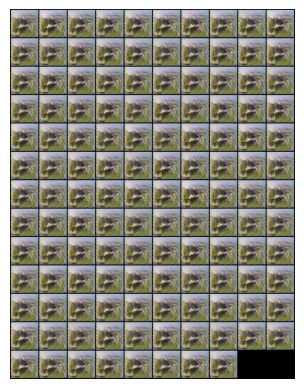

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(os.path.join(CFG.sample_dir, "fake_images-0131.png"))
plt.imshow(img)
plt.axis('off')
plt.show()

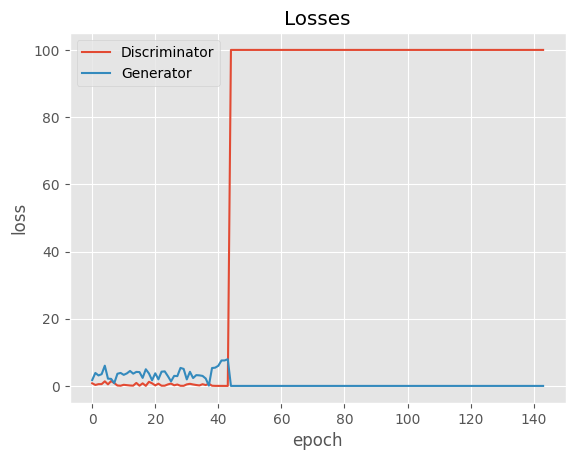

In [18]:
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

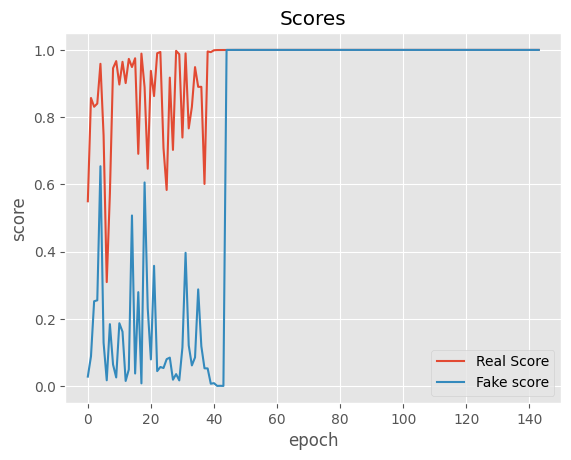

In [19]:
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");